In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting
import cmocean


/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


month_100m_ds_dict = {} 

for month in months: 
    month_100m_ds_dict[month] = xr.open_dataset(f'../output/{month}_normal_ds')

In [3]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


month_500m_ds_dict = {} 

for month in months: 
    month_500m_ds_dict[month] = xr.open_dataset(f'../output/{month}_500_m_scale_ds')

In [11]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076

times = month_100m_ds_dict[month].time.values
color_map = [
    [6.72862e-01, 1.39087e-01, 2.69400e-03],
    [5.08815e-01, 0.00000e+00, 0.00000e+00],
    [2.99417e-01, 3.66000e-04, 5.48000e-04],
    [0.00000e+00, 0.00000e+00, 6.00000e-06],
    [0.00000e+00, 1.20401e-01, 3.02675e-01],
    [0.00000e+00, 2.16583e-01, 5.24574e-01],
    [1.28047e-01, 4.92588e-01, 7.20288e-01],
    [1.88955e-01, 6.41309e-01, 7.92092e-01],
    [6.08240e-01, 8.92164e-01, 9.35547e-01],
    [9.04481e-01, 6.90489e-01, 0.00000e+00],
    [8.54070e-01, 5.10864e-01, 0.00000e+00],
    [7.77093e-01, 3.30180e-01, 8.82000e-04]
] #modified from Paraview's erdc_iceFire
ppm_convert = 1e6

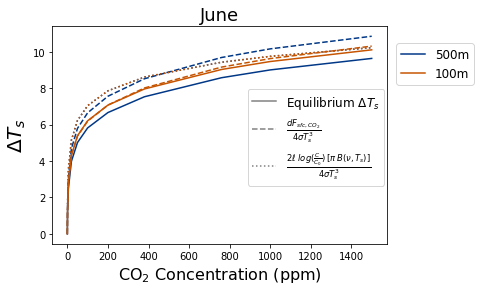

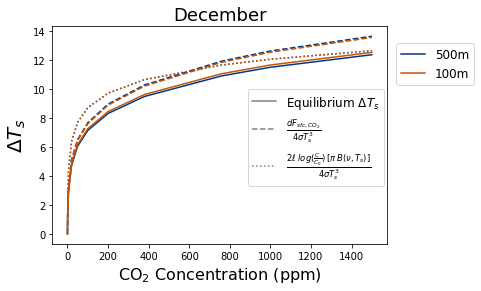

In [23]:
for month in ['June','December']:
    fig, ax1 = plt.subplots()
    plot_lines = []
    stef_boltz = 5.6E-8 #stefan boltzmann constant
    colors_list = [color_map[5],color_map[11]]
    for idx, month_ds_dict in enumerate([month_500m_ds_dict, month_100m_ds_dict]):
        c = colors_list[idx]
        #plot the calculated sfc co2 effect dTs
        y = month_ds_dict[month]['sfc_co2_effect']/(4*stef_boltz*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
        x = month_ds_dict[month]['co2_lev']*ppm_convert
        plot1 = plt.plot(x, y, label = month, linestyle = '--', color = c)
        #plot the model dTs
        y = (month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat')- 
         month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat', co2_lev = 0))
        plot2 = plt.plot(x, y, label = month, linestyle = '-', color = c)
        #plot the estimated sfc co2 effect dTs
        y = month_ds_dict[month]['sfc_co2_estimate']/(4*stef_boltz*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
        plot3 = plt.plot(x, y, label = month, linestyle = ':', color = c)
        #labels
        plt.ylabel(r'$\Delta T_s$', fontsize = 20)
        plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
        plot_lines.append(plot2)
    #legends
    line = Line2D([0,1],[0,1],linestyle='-', color='grey')
    dash = Line2D([0,1],[0,1],linestyle='--', color='grey')
    dot =  Line2D([0,1],[0,1],linestyle=':', color='grey')
    legend1 = plt.legend([line, dash, dot],[r'Equilibrium $\Delta T_s$',
                                             r'$\frac{dF_{sfc,CO_2}}{4\sigma T_s^3}$', 
                                             r'$\frac{2 \ell \ log(\frac{C}{C_0})\:[\pi\, B(\nu, T_s)]}{4\sigma T_s^3}$'], fontsize = 12, bbox_to_anchor = [1.01, 0.74])
    plt.legend([l[0] for l in plot_lines], ['500m','100m'], fontsize = 12, bbox_to_anchor = [1.01, 0.95])
    plt.gca().add_artist(legend1)
    plt.title(month, fontsize = 18)
#plt.savefig('../figures/delta_Ts.png', dpi = 150, bbox_inches = 'tight')


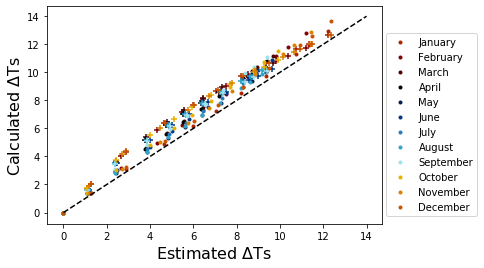

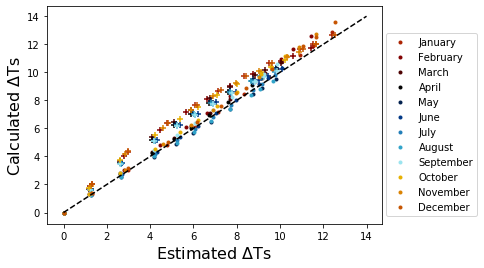

In [26]:
for idx, month_ds_dict in enumerate([month_500m_ds_dict, month_100m_ds_dict]):
    fig, ax = plt.subplots()
    color = iter(color_map)
    for month in months:
        x = month_ds_dict[month]['sfc_co2_effect']/(4*5.6E-8*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
        y = month_ds_dict[month]['sfc_co2_estimate']/(4*5.6E-8*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
        z = (month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat')- 
         month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat', co2_lev = 0))
        c = next(color)
        plt.scatter(z, x,
                label = month,
            color = c, marker = '.')
        plt.scatter(z, y,
            color = c, marker = '+')
    plt.plot(np.arange(0,15,1),np.arange(0,15,1), color = 'k', linestyle = '--')
    plt.xlabel(r'Estimated $\Delta$Ts', fontsize = 16)
    plt.ylabel(r'Calculated $\Delta$Ts', fontsize = 16)
    plt.legend(bbox_to_anchor = [1.3, 0.9]);
